In [1]:
import data_query as dq
import testing_process as tp
import importlib
import pandas as pd
importlib.reload(dq)
importlib.reload(tp)
import warnings
import re
warnings.simplefilter(action='ignore', category=Warning)

c:\Users\Le-Hao.Hsu\OneDrive - Foxconn Industrial Internet in North America\Desktop\Gavin\cims_test


### Symptom_repair_table

In [2]:
suggestion_query = '''
                    SELECT sls.prod_ver, sls.symptom_label, sls.message, sls.cycle_count,  slc.name as category, sls.repair_suggestion
                    FROM manufacturing_symptomlabelsuggestion sls
                    JOIN manufacturing_symptomlabelcategory slc
                    ON sls.category_id = slc.id;
                    '''
cat_df = tp.db_connect(suggestion_query)

### Overall information
1. Units that are completed after 2025-04-01
2. Completed defined by complete = 1 and station_id = Pack
3. Limited to production version: ACON or GLP
4. Units with at least one repair record

Till 2025/06/03, there are 22320 units matched

In [3]:
test_query = '''
SELECT mtr.serial_number, mtr.station, wo.production_version,
    SUBSTRING(CAST(msn.complete_date AS TEXT) FROM 1 FOR 19) complete_date,
    SUBSTRING(CAST(mtr.testing_date AS TEXT) FROM 1 FOR 19) AS testing_date,
    SUBSTRING(CAST(rm.repaired_date AS TEXT) FROM 1 FOR 19) AS repaired_date,
    mtr.result test_result, rm.result AS repair_result, mtr.symptom_info, rm.failure_description
FROM public.manufacturing_serialnumber msn
LEFT JOIN manufacturing_testingresult mtr ON msn.serial_number = mtr.serial_number
LEFT JOIN public.manufacturing_repairmain rm ON mtr.rowid = rm.testing_result_id
LEFT JOIN public.manufacturing_workorder wo ON msn.workorder_id = wo.workorder_id
LEFT JOIN public.manufacturing_repairdetail rd ON rm.failure_sequence = rd.failure_sequence
WHERE wo.production_version IN ('ACON', 'GLP') 
    AND mtr.serial_number IN (
        SELECT DISTINCT mtr_sub.serial_number
        FROM manufacturing_testingresult mtr_sub
        LEFT JOIN public.manufacturing_repairmain rm_sub ON mtr_sub.rowid = rm_sub.testing_result_id
        WHERE rm_sub.result = 0 AND rm_sub.repaired_date IS NULL
    )
ORDER BY mtr.serial_number, mtr.testing_date, rm.repaired_date;
'''
summary_df = tp.db_connect(test_query)

In [4]:
copy_df = summary_df.copy()

In [5]:
copy_df['cycle'] = (
    copy_df.groupby(['serial_number', 'failure_description'])
              .cumcount() + 1
)


def extract_matching_msg(row):
    if row.get("repair_result") != 0:
        return None  # Only process rows where repair_result == 0

    info = row['symptom_info']
    target_label = row['failure_description']
    
    if isinstance(info, dict):
        for item in info.values():
            if item.get('symptom_label') == target_label:
                return item.get('symptom_msg')
    return None

copy_df['message'] = copy_df.apply(extract_matching_msg, axis=1)

In [6]:
work_label = ["pcierrors-high-lane_error-rate"]

In [7]:
cat_label = cat_df.symptom_label.unique()
lookup_df = copy_df[~copy_df['message'].isna()][['serial_number', 'station', 'testing_date', 'production_version', 'failure_description', 'cycle', 'message']]
lookup_df = lookup_df[lookup_df.failure_description.isin(cat_label)]

In [227]:
filter_results = []
for idx, row in lookup_df.iterrows():
    failure_description = row['failure_description']
    cycle_count = row['cycle']
    production_version = row['production_version']
    max_count = 5

    res = cat_df[
        (cat_df['symptom_label'] == failure_description) &
        (cat_df['cycle_count'] == (max_count if cycle_count >= 5 else cycle_count)) &
        (cat_df['prod_ver'] == production_version)
    ]
    filter_results.append(res)

In [13]:
PATTERN_DICT = {
    "Checking BMC boot readiness and get BMC IP Failed": [
        r"Switch to agora console failed.*", r"Failed to get IP address"
    ],
    "HB16 firmware check Failed": [
        r"Send command", r"Check HB16 version failed"
    ],
    "The sensor count of Config_check_HW is not matched.":[
        fr"OUTLET T {i}" for i in range(1, 4)
    ] + [r"P48V"],
    "Validate Diorite PN, SN and installed slot Failed": lambda msg: [
        fr"usb_loc {port}.*Timeout opening channel" 
        for port in ["1-1.1", "1-1.2", "1-1.7.1", "1-1.7.2"] if port in msg] + [
        fr"usb_loc {port}" 
        for port in ["1-1.1", "1-1.2", "1-1.7.1", "1-1.7.2"] if port in msg
    ],
    "pcierrors-high-lane_error-rate": lambda msg: (
        [
            rf"0000:({'|'.join(group)})\b"
            for group in [
                {"00", "01"}, {"20", "21"}, {"40", "41"}, {"60", "61"},
                {"80", "81"}, {"a0", "a1"}, {"c0", "c1"}, {"e0", "e1"}
            ]
            if (match := re.search(r"0000:([a-fA-F0-9]{2})", msg)) and match.group(1).lower() in group
        ]
        if re.search(r"0000:([a-fA-F0-9]{2})", msg)
        else []
    ),
    "Lower critical limit violated": lambda msg: (
        [rf"^got \d+ violations, exceeding threshold of \d+ for sensor fan{fan} tach\."
        for fan in range(0, 6)
        if f"sensor fan{fan}" in msg.lower()] +
        [r"^got \d+ violations, exceeding threshold of \d+ for sensor RTC 3V\."]
    ),
    "Diorite location validation failure": [
        r"Component diorite sn: .*? not found on unit", r"Component diorite sn \S+ location: \S+, expected location: \S+"
    ],
    "Create Host SSH Connection failed": [
        r"No address associated with hostname", r"Unable to connect to"
    ],
    "excessive-correctable-unclassified-cpu-errors": lambda msg: (
        [fr"CPU{i} UNCLASSIFIED" for i in range(0,2) if f"CPU{i}" in msg]
    ),

    "Update Foxconn BIOS Failed" : [
        r"^Update BIOS failed\..*", r"^Update BIOS failed\.(\r\n)?Exception message:.*" 
    ],
    "Total Sensors fail": [
        fr"OUTLET T {i}" for i in range(1, 4)
    ] + [r"P48V"],
    "unknown-pcie-location": lambda msg: (
        [
            rf"0000:({'|'.join(group)})\b"
            for group in [
                {"00", "01"}, {"20", "21"}, {"40", "41"}, {"60", "61"},
                {"80", "81"}, {"a0", "a1"}, {"c0", "c1"}, {"e0", "e1"}
            ]
            if (match := re.search(r"0000:([a-fA-F0-9]{2})", msg)) and match.group(1).lower() in group
        ]
        if re.search(r"0000:([a-fA-F0-9]{2})", msg)
        else []
    ),
    "pcierrors-high-receiver_error-rate": lambda msg: (
        [
            rf"0000:({'|'.join(group)})\b"
            for group in [
                {"00", "01"}, {"20", "21"}, {"40", "41"}, {"60", "61"},
                {"80", "81"}, {"a0", "a1"}, {"c0", "c1"}, {"e0", "e1"}
            ]
            if (match := re.search(r"0000:([a-fA-F0-9]{2})", msg)) and match.group(1).lower() in group
        ]
        if re.search(r"0000:([a-fA-F0-9]{2})", msg)
        else []
    ),
    "DMA stress test Failed": [
        "DMA channel not found in stress result",
        "Send command 'ls /root/run_dmatest_host_per.sh' failed.",
        "Send command 'ls /sys/module/dmatest/parameters/' failed.",
        r"Send command 'sh /root/run_dmatest_host_per\.sh .*' failed\."  # <- regex with variable arguments
    ],
    "Update Google BIOS Failed": [
        r"Send command '/export/hda3/meltan/biosintegrity/biosintegrity --expected_bios_version=.*?' failed\.\s*Failure Info:",
        r"Update BIOS failed\.\s*.*bios\.bin\s*.*bios\.sig"
    ],
    "HB16 location validation failure": [
        r"Component HB16 SN: .*? not found on unit", r"Component HB16 SN \S+ location: \S+, expected location: \S+"
    ],
    "FRU infos validation failure": [
        r"(SN: [\w-]+ [\w-]+ not (found on unit|match unit)|PN:\s?[\w-]+ not (found on unit|match unit))", 
        r"SN: PDF\w+ not found on unit",  
        r"SN: IPB\w+ not found on unit",  
        r"SN: AST\w+ not found on unit",  
        r"SN: AAH\w+ not found on unit",  
        r"SN: KW\w+-\w+ \w+ not found on unit",  
        r"SN: HAB\w+ not found on unit"   
    ]
}

In [14]:
import re
def select_best_message(data, failure_label, symptom_msg, pattern_dict=None):
    # Step 1: Exact match
    for idx, suggestion in data.iterrows():
        if suggestion['message'].strip() == symptom_msg.strip():
            print("Find exact match")
            return suggestion['message']

    # Step 2: Get patterns from matched label in pattern dict
    if pattern_dict and failure_label in pattern_dict:
        patterns = pattern_dict[failure_label](symptom_msg) \
            if callable(pattern_dict[failure_label]) else pattern_dict[failure_label]
    else:
        patterns = []
    # Step 3: Check if any pattern matches
    for pattern in patterns:
        if re.search(pattern, symptom_msg, re.IGNORECASE | re.DOTALL):
            # Pattern matched the input — now match it in suggestion
            for idx, suggestion in data.iterrows():
                if re.search(pattern, suggestion["message"], re.IGNORECASE | re.DOTALL):
                    print("Find match")
                    return suggestion['message']
    print("no match and return the first record")
    print("messages options include")
    i = 1
    for item in data.message.to_list():
        print(f"{i}.")
        i+=1
        print(item)
    return data['message'].iloc[0]


In [11]:
repair_query = '''
    SELECT 
    wo.model_name, wo.production_version, mtr.serial_number, mtr.station,
    SUBSTRING(CAST(msn.complete_date AS TEXT) FROM 1 FOR 19) complete_date,
    SUBSTRING(CAST(mtr.testing_date AS TEXT) FROM 1 FOR 19) AS testing_date,
    SUBSTRING(CAST(rm.repaired_date AS TEXT) FROM 1 FOR 19) AS repaired_date,
    mtr.result test_result, rm.result AS repair_result, mtr.symptom_info, rm.failure_description,
    sls.symptom_label, message, cycle_count, slc.name
    FROM public.manufacturing_serialnumber msn
    LEFT JOIN manufacturing_testingresult mtr on msn.serial_number = mtr.serial_number
    LEFT JOIN public.manufacturing_repairmain rm ON mtr.rowid = rm.testing_result_id
    LEFT JOIN public.manufacturing_workorder wo ON msn.workorder_id = wo.workorder_id
    LEFT JOIN public.manufacturing_repairdetail rd ON rm.failure_sequence = rd.failure_sequence
    LEFT JOIN public.manufacturing_symptomlabelsuggestion sls ON rd.symptom_suggestion_id = sls.id
    LEFT JOIN public.manufacturing_symptomlabelcategory slc ON sls.category_id = slc.id
    WHERE msn.complete_date >= '2025-04-01'
    AND msn.completed = 1 AND msn.station_id = 'Pack' AND wo.production_version in ('ACON', 'GLP')
    AND mtr.serial_number IN (
        -- Ensure serial numbers have at least one result = 0
        SELECT mtr_sub.serial_number
        FROM manufacturing_testingresult mtr_sub
        LEFT JOIN public.manufacturing_repairmain rm_sub ON mtr_sub.rowid = rm_sub.testing_result_id
        LEFT JOIN public.manufacturing_repairdetail rd_sub ON rm_sub.failure_sequence = rd_sub.failure_sequence
        WHERE mtr_sub.result = 0 
        GROUP BY mtr_sub.serial_number
    )
    ORDER BY mtr.serial_number, msn.complete_date, mtr.testing_date, rm.repaired_date;
'''
repair_df = tp.db_connect(repair_query)

In [12]:
repair_df = repair_df[['production_version', 'serial_number', 'station', 'repaired_date', 'test_result','repair_result', 'symptom_info', 'failure_description', 'symptom_label','message', 'cycle_count', 'name']]

In [15]:
def process_sn_group(sn_group, cat_df):
    sn_group = sn_group.copy()

    # Filter valid rows once
    valid_rows = sn_group[
        (sn_group["test_result"] == 0) &
        (sn_group["symptom_info"].apply(lambda x: isinstance(x, dict) and len(x) > 0))&
        (pd.to_datetime(sn_group["repaired_date"]) < pd.Timestamp("2025-05-07"))
    ]

    # Step 1: Fill in symptom_label and message
    for idx, row in valid_rows.iterrows():
        if pd.isna(row["symptom_label"]):
            for item in row["symptom_info"].values():
                if item.get("symptom_label") == row["failure_description"]:
                    sn_group.at[idx, "symptom_label"] = item["symptom_label"]
                    sn_group.at[idx, "message"] = item.get("symptom_msg", "")
                    break

    # Step 2: Assign cycle_count per label
    label_counter = {}
    for idx in valid_rows.index:
        label = sn_group.at[idx, "symptom_label"]
        if pd.notna(label):
            label_counter[label] = label_counter.get(label, 0) + 1
            sn_group.at[idx, "cycle_count"] = label_counter[label]

    # Step 3: Assign category name
    for idx in valid_rows.index:
        try:
            row = sn_group.loc[idx]
            max_cycle_count = 5
            # Fetch candidates from cat_df 
            matched_candidates = cat_df[
                (cat_df["symptom_label"] == row["symptom_label"]) &
                (cat_df["prod_ver"] == row["production_version"]) &
                (cat_df["cycle_count"] == min(row["cycle_count"], max_cycle_count))  # apply cap
            ]
            if len(matched_candidates) == 1:
                sn_group.at[idx, "name"] = matched_candidates["category"].values[0]
            if not matched_candidates.empty and len(matched_candidates)>1:
                selected_row = select_best_message(
                    matched_candidates,
                    row["symptom_label"],
                    row["message"],
                    tp.PATTERN_DICT
                )

                if selected_row is not None:
                    sn_group.at[idx, "name"] = selected_row["category"]
        except Exception as e:
            pass
    return sn_group
def select_best_message(msg_ref_qs, failure_label, symptom_msg, pattern_dict=None):
    # Step 1: Exact match
    for idx, row in msg_ref_qs.iterrows():
        if row['message'].strip() == symptom_msg.strip():
            return row
    # Step 2: Get patterns from matched label in pattern dict
    if pattern_dict and failure_label in pattern_dict:
        patterns = pattern_dict[failure_label](symptom_msg) \
            if callable(pattern_dict[failure_label]) else pattern_dict[failure_label]
    else:
        patterns = []
    # Step 3: Check if any pattern matches
    for pattern in patterns:
        if re.search(pattern, symptom_msg, re.IGNORECASE | re.DOTALL):
            # Pattern matched the input — now match it in suggestion
            for idx, row in msg_ref_qs.iterrows():
                if re.search(pattern, row.message, re.IGNORECASE | re.DOTALL):
                    return row

    return msg_ref_qs[0]


### Clean data
1. Create serial number group
2. Processs rows with failed test (test_result = 0) + symptom_info = dict & at least 1 record + repaired_date before 2025-05-07(date start to save record)
3. For rows without symptom_label, use failure_description to match symptom_label in symptom_info, stored symptom_label and symptom_message for the first match, otherwise NA

In [16]:
result_df_list = []

for sn, group in repair_df.groupby('serial_number'):
    processed = process_sn_group(group, cat_df)
    result_df_list.append(processed)

final_df = pd.concat(result_df_list, ignore_index=True)


Remove units with repair records are not assigned category

In [18]:
# Clean data!
drop_sn = final_df[(final_df['test_result']==0)&(final_df.name.isna())].serial_number.unique()
selected_cols = ["serial_number", "production_version", "station", "testing_date", "repaired_date", "test_result", "repair_result", "symptom_label", "message", "name"]
clean_repair_df = final_df[(~final_df.serial_number.isin(drop_sn))].reset_index(drop=True)[selected_cols].drop_duplicates()

KeyError: "['testing_date'] not in index"

Compare the implementation of category by separating data to 

* **BEFORE**: repair date between 2025/03/15 - 2025/04/15
* **AFTER**: repair date after 2025/05/03 (include the first pass record after the last repair record)

In [338]:
before_df = clean_repair_df[(clean_repair_df['repaired_date']<'2025-04-15')&(clean_repair_df['repaired_date']>='2025-03-15')]
after_rows = []

for sn, group in clean_repair_df.groupby('serial_number'):
    # Already in chronological order
    start_idx = group[group['repaired_date'] >= '2025-05-03'].index
    if len(start_idx) == 0:
        continue

    start = start_idx[0]
    sub_group = group.loc[start:]
    
    # Stop at first NaT repaired_date (inclusive)
    stop_idx = sub_group[sub_group['repaired_date'].isna()].index
    if len(stop_idx) > 0:
        end = stop_idx[0]
        after_rows.append(sub_group.loc[:end])
    else:
        after_rows.append(sub_group)

# Combine
after_df = pd.concat(after_rows, ignore_index=True)



In [359]:
len(before_df.serial_number.unique()), len(after_df.serial_number.unique())

(4177, 4966)

In [340]:
hybrid_sn = (set(before_df.serial_number.unique()) & set(after_df.serial_number.unique()))

In [343]:
hybrid_prev_df = before_df[before_df.serial_number.isin(hybrid_sn)]
hybrid_post_df = after_df[after_df.serial_number.isin(hybrid_sn)]

In [345]:
# Count number of loops per SN
hybrid_prev_df['is_loop'] = hybrid_prev_df['test_result'] == 0 
hybrid_post_df['is_loop'] = hybrid_post_df['test_result'] == 0

# Count number of loops per SN
loop_counts_before = hybrid_prev_df[hybrid_prev_df['is_loop']].groupby('serial_number').size()
loop_counts_after = hybrid_post_df[hybrid_post_df['is_loop']].groupby('serial_number').size()

min_len = min(len(loop_counts_before), len(loop_counts_after))

sampled_loop_counts_before = loop_counts_before.sample(n=min_len)
sampled_loop_counts_after = loop_counts_after.sample(n=min_len)
# Compute the averages using matched sample sizes
avg_loops_before = sampled_loop_counts_before.mean()
avg_loops_after = sampled_loop_counts_after.mean()
print(f"[SAMPLED] Average repair loops BEFORE 2025-04-15: {avg_loops_before:.2f}")
print(f"          Average repair loops AFTER  2025-04-15: {avg_loops_after:.2f}")

[SAMPLED] Average repair loops BEFORE 2025-04-15: 2.16
          Average repair loops AFTER  2025-04-15: 1.56


In [348]:
def compute_resolution_before(group):
    if len(group) == 1:
        return None
    else:
        first_test = group.iloc[0]['repaired_date']
        last_repair = group['repaired_date'].iloc[-1]
        return (last_repair - first_test).total_seconds() / 3600

def compute_resolution_after(group):
    first_repair = group.iloc[0]['repaired_date']
    last_test = group.iloc[-1]['testing_date']
    return (last_test - first_repair).total_seconds() / 3600


hybrid_prev_df['testing_date'] = pd.to_datetime(hybrid_prev_df['testing_date'])
hybrid_prev_df['repaired_date'] = pd.to_datetime(hybrid_prev_df['repaired_date'])
resolution_times_before = hybrid_prev_df.groupby('serial_number').apply(compute_resolution_before).dropna()

hybrid_post_df['testing_date'] = pd.to_datetime(hybrid_post_df['testing_date'])
hybrid_post_df['repaired_date'] = pd.to_datetime(hybrid_post_df['repaired_date'])
resolution_times_after = hybrid_post_df.groupby('serial_number').apply(compute_resolution_after).dropna()

min_len = min(len(resolution_times_before), len(resolution_times_after))

sampled_before = resolution_times_before.sample(n=min_len)
sampled_after = resolution_times_after.sample(n=min_len)
print(f"Average Resolution Time BEFORE: {sampled_before.mean():.2f} hrs")
print(f"Average Resolution Time AFTER : {sampled_after.mean():.2f} hrs")

Average Resolution Time BEFORE: 97.26 hrs
Average Resolution Time AFTER : 46.74 hrs


In [349]:
# Count number of loops per SN
before_df['is_loop'] = before_df['test_result'] == 0 
after_df['is_loop'] = after_df['test_result'] == 0

# Count number of loops per SN
loop_counts_before = before_df[before_df['is_loop']].groupby('serial_number').size()
loop_counts_after = after_df[after_df['is_loop']].groupby('serial_number').size()

min_len = min(len(loop_counts_before), len(loop_counts_after))

sampled_loop_counts_before = loop_counts_before.sample(n=min_len)
sampled_loop_counts_after = loop_counts_after.sample(n=min_len)
# Compute the averages using matched sample sizes
avg_loops_before = sampled_loop_counts_before.mean()
avg_loops_after = sampled_loop_counts_after.mean()
print(f"[SAMPLED] Average repair loops BEFORE 2025-04-15: {avg_loops_before:.2f}")
print(f"          Average repair loops AFTER  2025-04-15: {avg_loops_after:.2f}")

[SAMPLED] Average repair loops BEFORE 2025-04-15: 1.53
          Average repair loops AFTER  2025-04-15: 1.39


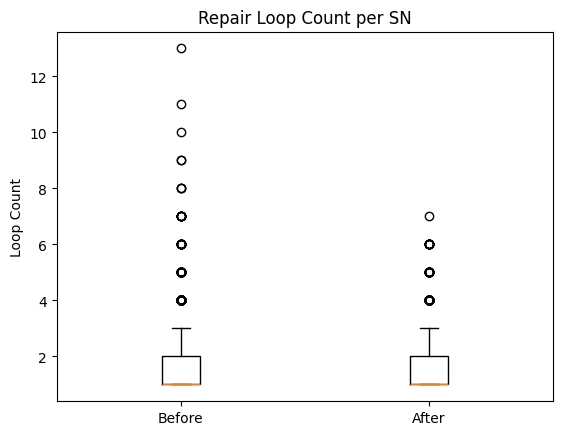

In [350]:
plt.boxplot([sampled_loop_counts_before, sampled_loop_counts_after], labels=['Before', 'After'])
plt.title("Repair Loop Count per SN")
plt.ylabel("Loop Count")
plt.show()

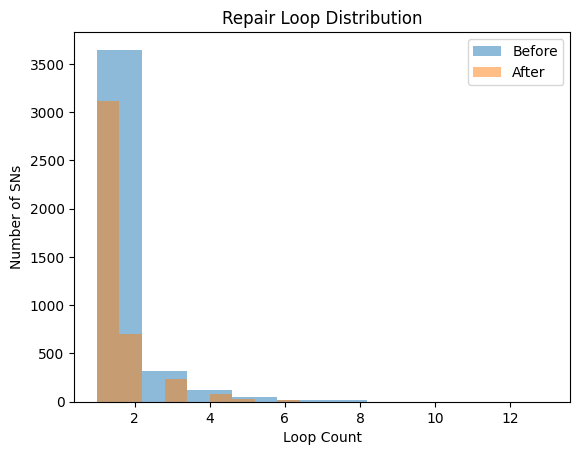

In [351]:
plt.hist(sampled_loop_counts_before, bins=10, alpha=0.5, label='Before')
plt.hist(sampled_loop_counts_after, bins=10, alpha=0.5, label='After')
plt.legend()
plt.title("Repair Loop Distribution")
plt.xlabel("Loop Count")
plt.ylabel("Number of SNs")
plt.show()


In [352]:
def compute_resolution_before(group):
    if len(group) == 1:
        return None
    else:
        first_test = group.iloc[0]['repaired_date']
        last_repair = group['repaired_date'].iloc[-1]
        return (last_repair - first_test).total_seconds() / 3600

def compute_resolution_after(group):
    first_repair = group.iloc[0]['repaired_date']
    last_test = group.iloc[-1]['testing_date']
    return (last_test - first_repair).total_seconds() / 3600


after_df['testing_date'] = pd.to_datetime(after_df['testing_date'])
after_df['repaired_date'] = pd.to_datetime(after_df['repaired_date'])
resolution_times_after = after_df.groupby('serial_number').apply(compute_resolution_after).dropna()

before_df['testing_date'] = pd.to_datetime(before_df['testing_date'])
before_df['repaired_date'] = pd.to_datetime(before_df['repaired_date'])
resolution_times_before = before_df.groupby('serial_number').apply(compute_resolution_before).dropna()

min_len = min(len(resolution_times_before), len(resolution_times_after))

sampled_before = resolution_times_before.sample(n=min_len)
sampled_after = resolution_times_after.sample(n=min_len)
print(f"Average Resolution Time BEFORE: {sampled_before.mean():.2f} hrs")
print(f"Average Resolution Time AFTER : {sampled_after.mean():.2f} hrs")

Average Resolution Time BEFORE: 80.63 hrs
Average Resolution Time AFTER : 16.26 hrs


In [355]:
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(resolution_times_before, resolution_times_after, alternative='two-sided')
print(f"Mann–Whitney U test p-value: {p_value:.4f}")

Mann–Whitney U test p-value: 0.0000


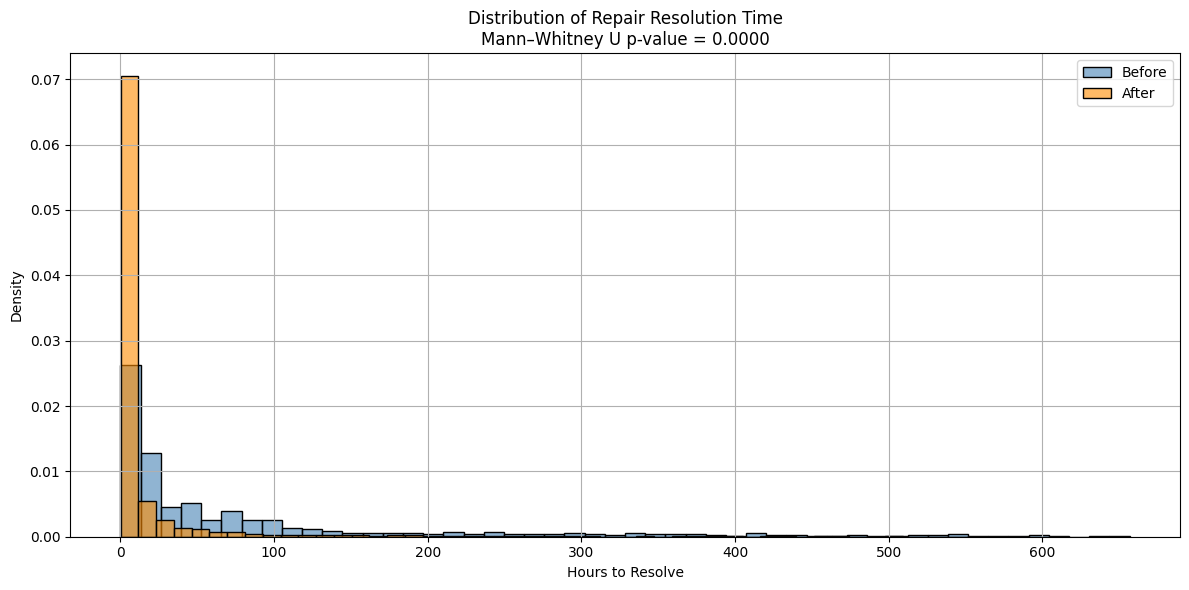

In [362]:
import seaborn as sns
from scipy.stats import mannwhitneyu
import numpy as np
import matplotlib.pyplot as plt
# Calculate mean and median
mean_before = resolution_times_before.mean()
mean_after = resolution_times_after.mean()
median_before = np.median(resolution_times_before)
median_after = np.median(resolution_times_after)

# Perform Mann–Whitney U test
stat, p_value = mannwhitneyu(resolution_times_before, resolution_times_after, alternative='greater')

# Compute % of SNs resolved within 24h
within_24h_before = (resolution_times_before <= 24).mean() * 100
within_24h_after = (resolution_times_after <= 24).mean() * 100

# Plot
plt.figure(figsize=(12, 6))
sns.histplot(resolution_times_before, bins=50, color='steelblue', label='Before', stat='density', kde=False, alpha=0.6)
sns.histplot(resolution_times_after, bins=50, color='darkorange', label='After', stat='density', kde=False, alpha=0.6)

# Labels
plt.title(f'Distribution of Repair Resolution Time\nMann–Whitney U p-value = {p_value:.4f}')
plt.xlabel('Hours to Resolve')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Create summary table
summary = pd.DataFrame({
    'Group': ['Before', 'After'],
    'Mean (h)': [mean_before, mean_after],
    'Median (h)': [median_before, median_after],
    'Resolved ≤24h (%)': [within_24h_before, within_24h_after]
})


In [358]:
summary

,Group,Mean (h),Median (h),Resolved ≤24h (%)
0,Before,80.627947,24.802083,49.007634
1,After,16.155154,3.150972,88.099074
